In [1]:
import gym
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import deque
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.models import Sequential

# 환경 -> Agent(Action) -> Run(Reward, State) -> 저장 -> weight 업데이트 -> memory 통한 학습

# Agent 정의 (파라미터)
class DQNAgent(object):
    def __init__(self, state_size, action_size, train):
        self.state_size = state_size 
        self.action_size = action_size

        self.discount_factor = 0.99 # discount rate
        self.learning_rate = 0.001
        self.epsilon = 1.0 if train else 0.001 # exploration rate
        self.epsilon_decay = 0.9999 if train else 1.0
        # 충분히 탐험을 하지 않으면 local에 빠지기 쉬움
        # 그래서 epsilon을 사용하는데 이러면 수렴속도가 느려져서 학습속도가 느려짐
        # 따라서 이를 해결하기 위해 epsilon decay를 사용
        self.epsilon_min = 0.001 if train else self.epsilon
        self.train_start = 500 # 500 episode의 경험이 쌓이기 전에는 train을 시작하지 않음
        self.batch_size = 32

        self.memory = deque(maxlen=1000000) # FIFO 자료구조 (replay memory)

        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model() 

    # 모델 구성
    # full connected layer, loss = mse, optimizer = adam
    def build_model(self): 
        model = Sequential()
        model.add(Dense(24,
                        input_dim=self.state_size,
                        activation="relu"))
        model.add(Dense(48,
                        activation="relu"))
        model.add(Dense(self.action_size,
                        activation="linear"))
        model.compile(loss="mse", optimizer=RMSprop(lr=self.learning_rate))
        return model

    # 위에서 구한 model의 weight로 target model 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # weight값 외부 파일로 저장 혹은 불러오기
    def load_model(self, path_to_model):
        if os.path.exists(path_to_model):
            self.model.load_weights(path_to_model)
            self.update_target_model()
    def save_model(self, path_to_model):
        self.model.save_weights(path_to_model)

    # action 결정
    # epsilon값보다 작은 값이 나오면 랜덤하게 action을 취함
    # epsilon값보다 더 높을 경우 model을 통해 예측한 값을 사용
    
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:  # exploration
            return random.randrange(self.action_size)
        else:
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])

    def add_sample(self, state, action, reward, next_state, is_done):
        self.memory.append((state, action, reward, next_state, is_done))

    def train_model(self):
        if len(self.memory) < self.train_start:
            return  # not enough experiences yet
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size) # deque의 값을 랜덤하게 batch에 저장

        states = []
        next_states = []
        # make input for dnn
        for s, a, r, n, t in mini_batch:
            states.append(s[0])
            next_states.append(n[0])

        states = np.array(states)
        next_states = np.array(next_states)

        target = self.model.predict(states)
        qhat = self.target_model.predict(next_states)

        for i, experience in enumerate(mini_batch):
            s, a, r, n, t = experience  # (state, action, reward, next_state, is_done)
            if t:
                target[i][a] = r
            else:
                target[i][a] = r + self.discount_factor * (np.amax(qhat[i]))  # DQN
            # mini batch 에 대해서 bootstrap으로 바로 윗 줄을 Q가 update 되어야 할 타겟으로 설정
            # DQN pseudo code 참조

        self.model.fit(states, target, batch_size=batch_size, epochs=1, verbose=0)
        # episode 마다 업데이트

    def update_epsilon(self, episode, step):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)


def reshape_state(state):
    return np.expand_dims(state, axis=0)


def plot_scores(scores):
    plt.plot(scores)
    plt.ylabel("Scores")
    plt.xlabel("Episodes")
    plt.plot()
    plt.savefig("./cartpole_dqn1.png")
    plt.show()


def run_cartpole(total_episodes=1000,
                 save_weights_interval=50,
                 weights_path="C:/ykio/tobigs/s_week4/cartpole_dqn.h5",
                 render=True,
                 train=True,
                 target_update_episode_interval=20,
                 stop_average_score=-1):
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    # 환경 설정

    agent = DQNAgent(state_size, action_size, train)
    agent.load_model(weights_path)
    scores = []
    mva_score = 0
    for episode in range(total_episodes):
        done = False
        state = env.reset()
        state = reshape_state(state)
        score = 0
        step = 0
        while not done:
            if render:
                env.render()

            step += 1
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = reshape_state(next_state)

            if train:
                agent.add_sample(state, action, reward, next_state, done)
                agent.update_epsilon(episode, step)
            score += reward
            state = next_state

        # episode is done
        if train:
            agent.train_model()
            if episode > 0 and episode % target_update_episode_interval == 0:
                agent.update_target_model()
            scores.append(score)
            mva_score = mva_score * 0.9 + score * 0.1 if len(scores) > 5 else np.average(scores)
            # 큰 의미는 없음
        
        if episode % 500 == 0:
            print("Game over: {} / step: {} / score: {} / average_score: {:.5f} / epsilon: {:.5f}".format(episode,
                                                                                                      step,
                                                                                                      score,
                                                                                                      mva_score,
                                                                                                      agent.epsilon))

        if episode > 0 and episode % save_weights_interval == 0:
            agent.save_model(weights_path)
        if 0 < stop_average_score <= mva_score:
            break

    # save again
    agent.save_model(weights_path)
    plot_scores(scores)
    print("Average score: {}".format(np.mean(scores)))

    env.close()

Using TensorFlow backend.


Game over: 0 / step: 19 / score: 19.0 / average_score: 19.00000 / epsilon: 0.99810
Game over: 100 / step: 18 / score: 18.0 / average_score: 19.96041 / epsilon: 0.80243
Game over: 200 / step: 22 / score: 22.0 / average_score: 13.91601 / epsilon: 0.67915
Game over: 300 / step: 12 / score: 12.0 / average_score: 13.11051 / epsilon: 0.59124
Game over: 400 / step: 11 / score: 11.0 / average_score: 12.87729 / epsilon: 0.51164
Game over: 500 / step: 14 / score: 14.0 / average_score: 14.12390 / epsilon: 0.44196
Game over: 600 / step: 10 / score: 10.0 / average_score: 18.25631 / epsilon: 0.35115
Game over: 700 / step: 21 / score: 21.0 / average_score: 68.92629 / epsilon: 0.13550
Game over: 800 / step: 30 / score: 30.0 / average_score: 45.62029 / epsilon: 0.08309
Game over: 900 / step: 34 / score: 34.0 / average_score: 41.08637 / epsilon: 0.05803
Game over: 1000 / step: 54 / score: 54.0 / average_score: 45.21122 / epsilon: 0.04151
Game over: 1100 / step: 43 / score: 43.0 / average_score: 35.42198

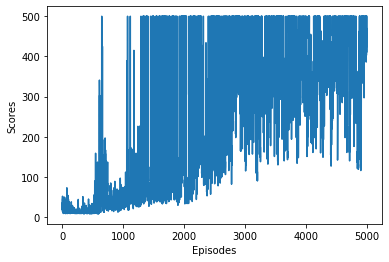

Average score: 232.7282


In [4]:
if __name__ == "__main__":
    run_cartpole(render=False,
                 train=True,
                 total_episodes=5000,
                 save_weights_interval=1000,
                 target_update_episode_interval=100,
                 stop_average_score=-1,
                 weights_path="C:/ykio/tobigs/s_week4/cartpole_dqn100.h5")

Game over: 0 / step: 13 / score: 13.0 / average_score: 13.00000 / epsilon: 0.99870
Game over: 100 / step: 24 / score: 24.0 / average_score: 41.90798 / epsilon: 0.75230
Game over: 200 / step: 54 / score: 54.0 / average_score: 79.25062 / epsilon: 0.46685
Game over: 300 / step: 52 / score: 52.0 / average_score: 123.43638 / epsilon: 0.13520
Game over: 400 / step: 377 / score: 377.0 / average_score: 445.39106 / epsilon: 0.00419
Game over: 500 / step: 83 / score: 83.0 / average_score: 417.68112 / epsilon: 0.00100
Game over: 600 / step: 122 / score: 122.0 / average_score: 402.47463 / epsilon: 0.00100
Game over: 700 / step: 500 / score: 500.0 / average_score: 408.99553 / epsilon: 0.00100
Game over: 800 / step: 500 / score: 500.0 / average_score: 469.18864 / epsilon: 0.00100
Game over: 900 / step: 500 / score: 500.0 / average_score: 440.92643 / epsilon: 0.00100
Game over: 1000 / step: 500 / score: 500.0 / average_score: 388.01928 / epsilon: 0.00100
Game over: 1100 / step: 409 / score: 409.0 / a

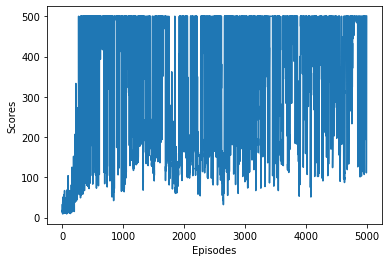

Average score: 351.7128


In [4]:
if __name__ == "__main__":
    run_cartpole(render=False,
                 train=True,
                 total_episodes=5000,
                 save_weights_interval=1000,
                 target_update_episode_interval=50,
                 stop_average_score=-1,
                 weights_path="C:/ykio/tobigs/s_week4/cartpole_dqn50.h5")

Game over: 0 / step: 22 / score: 22.0 / average_score: 22.00000 / epsilon: 0.99780
Game over: 100 / step: 12 / score: 12.0 / average_score: 16.86042 / epsilon: 0.81001
Game over: 200 / step: 20 / score: 20.0 / average_score: 15.58768 / epsilon: 0.67461
Game over: 300 / step: 16 / score: 16.0 / average_score: 12.64614 / epsilon: 0.58894
Game over: 400 / step: 12 / score: 12.0 / average_score: 12.88143 / epsilon: 0.51745
Game over: 500 / step: 11 / score: 11.0 / average_score: 12.31994 / epsilon: 0.45505
Game over: 600 / step: 12 / score: 12.0 / average_score: 14.09975 / epsilon: 0.39942
Game over: 700 / step: 14 / score: 14.0 / average_score: 15.17300 / epsilon: 0.35181
Game over: 800 / step: 11 / score: 11.0 / average_score: 25.27552 / epsilon: 0.27591
Game over: 900 / step: 20 / score: 20.0 / average_score: 25.64398 / epsilon: 0.18252
Game over: 1000 / step: 38 / score: 38.0 / average_score: 42.13317 / epsilon: 0.13878
Game over: 1100 / step: 18 / score: 18.0 / average_score: 23.18550

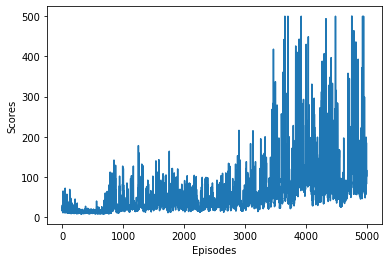

Average score: 57.2152


In [8]:
if __name__ == "__main__":
    run_cartpole(render=False,
                 train=True,
                 total_episodes=5000,
                 save_weights_interval=1000,
                 target_update_episode_interval=10,
                 stop_average_score=-1,
                 weights_path="C:/ykio/tobigs/s_week4/cartpole_dqn10.h5")

In [9]:
if __name__ == "__main__":
    run_cartpole(render=False,
                 train=True,
                 total_episodes=5000,
                 save_weights_interval=1000,
                 target_update_episode_interval=200,
                 stop_average_score=-1,
                 weights_path="C:/ykio/tobigs/s_week4/cartpole_dqn200.h5")

Game over: 0 / step: 30 / score: 30.0 / average_score: 30.00000 / epsilon: 0.99700
Game over: 100 / step: 12 / score: 12.0 / average_score: 16.95817 / epsilon: 0.79955
Game over: 200 / step: 16 / score: 16.0 / average_score: 15.53899 / epsilon: 0.67448
Game over: 300 / step: 12 / score: 12.0 / average_score: 15.72743 / epsilon: 0.57165
Game over: 400 / step: 12 / score: 12.0 / average_score: 14.25814 / epsilon: 0.48737
Game over: 500 / step: 17 / score: 17.0 / average_score: 22.35768 / epsilon: 0.40712
Game over: 600 / step: 20 / score: 20.0 / average_score: 30.47669 / epsilon: 0.33836
Game over: 700 / step: 16 / score: 16.0 / average_score: 20.08204 / epsilon: 0.28778
Game over: 800 / step: 34 / score: 34.0 / average_score: 37.24957 / epsilon: 0.22767
Game over: 900 / step: 31 / score: 31.0 / average_score: 45.85475 / epsilon: 0.14987
Game over: 1000 / step: 22 / score: 22.0 / average_score: 31.21201 / epsilon: 0.10258
Game over: 1100 / step: 125 / score: 125.0 / average_score: 69.094

Average score: 148.2146


Game over: 0 / step: 23 / score: 23.0 / average_score: 23.00000 / epsilon: 0.99770
Game over: 500 / step: 10 / score: 10.0 / average_score: 39.86182 / epsilon: 0.40367
Game over: 1000 / step: 77 / score: 77.0 / average_score: 52.31629 / epsilon: 0.02722
Game over: 1500 / step: 78 / score: 78.0 / average_score: 56.73237 / epsilon: 0.00257
Game over: 2000 / step: 500 / score: 500.0 / average_score: 324.40573 / epsilon: 0.00100
Game over: 2500 / step: 362 / score: 362.0 / average_score: 297.41815 / epsilon: 0.00100
Game over: 3000 / step: 178 / score: 178.0 / average_score: 343.53551 / epsilon: 0.00100
Game over: 3500 / step: 190 / score: 190.0 / average_score: 300.78221 / epsilon: 0.00100
Game over: 4000 / step: 219 / score: 219.0 / average_score: 219.50202 / epsilon: 0.00100
Game over: 4500 / step: 208 / score: 208.0 / average_score: 256.18186 / epsilon: 0.00100
Game over: 5000 / step: 210 / score: 210.0 / average_score: 209.40123 / epsilon: 0.00100
Game over: 5500 / step: 152 / score: 

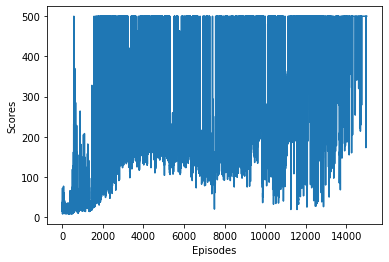

Average score: 269.7926


In [3]:
if __name__ == "__main__":
    run_cartpole(render=False,
                 train=True,
                 total_episodes=15000,
                 save_weights_interval=1000,
                 target_update_episode_interval=100,
                 stop_average_score=-1,
                 weights_path="C:/ykio/tobigs/s_week4/cartpole_dqn15000.h5")

In [ ]:
if __name__ == "__main__":
    run_cartpole(render=True,
                 train=False,
                 weights_path="C:/ykio/tobigs/s_week4/cartpole_dqn15000.h5")